[View in Colaboratory](https://colab.research.google.com/github/sharathsrini/Extended-Kalman-Filter-for-Sensor-Fusion/blob/master/dubins_2.0.ipynb)

Dubins path planner sample start!!
('px:', [0.0, -0.05235987755982989, -0.10464799772720926, -0.156721042399262, -0.20843628298009498, -0.2596519715899584, -0.31022772958633155, -0.36002493233202415, -0.4089070891556714, -0.4567402174631768, -0.5033932099746893, -0.5487381940805447, -0.5926508823312001, -0.635010913100494, -0.6757021804884973, -0.7146131525597148, -0.7516371770443678, -0.7866727736648524, -0.8196239122861262, -0.8504002761276338, -0.8789175093153246, -0.9050974480952396, -0.9288683350749283, -0.9501650159054734, -0.9689291178650327, -0.9851092098544115, -0.9986609433661316, -1.0095471740406066, -1.0177380634762505, -1.0232111610144623, -1.0259514652753194, -1.0259514652753194, -1.0232111610144623, -1.0177380634762507, -1.0095471740406068, -0.9986609433661315, -0.9851092098544114, -0.9689291178650324, -0.9501650159054733, -0.9288683350749282, -0.9050974480952395, -0.8789175093153245, -0.8504002761276338, -0.8196239122861262, -0.7866727736648524, -0.7516371770443679, -0.

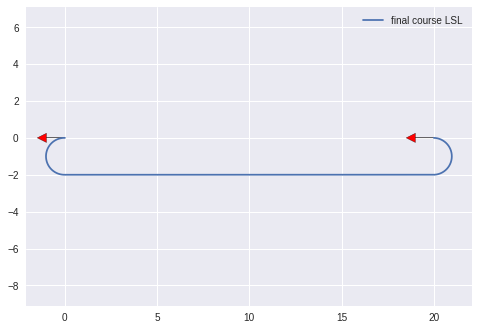

In [11]:
import math


def mod2pi(theta):
    return theta - 2.0 * math.pi * math.floor(theta / 2.0 / math.pi)


def pi_2_pi(angle):
    return (angle + math.pi) % (2*math.pi) - math.pi


def LSL(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    tmp0 = d + sa - sb

    mode = ["L", "S", "L"]
    p_squared = 2 + (d * d) - (2 * c_ab) + (2 * d * (sa - sb))
    if p_squared < 0:
        return None, None, None, mode
    tmp1 = math.atan2((cb - ca), tmp0)
    t = mod2pi(-alpha + tmp1)
    p = math.sqrt(p_squared)
    q = mod2pi(beta - tmp1)
    #  print(math.degrees(t), p, math.degrees(q))

    return t, p, q, mode


def RSR(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    tmp0 = d - sa + sb
    mode = ["R", "S", "R"]
    p_squared = 2 + (d * d) - (2 * c_ab) + (2 * d * (sb - sa))
    if p_squared < 0:
        return None, None, None, mode
    tmp1 = math.atan2((ca - cb), tmp0)
    t = mod2pi(alpha - tmp1)
    p = math.sqrt(p_squared)
    q = mod2pi(-beta + tmp1)

    return t, p, q, mode


def LSR(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    p_squared = -2 + (d * d) + (2 * c_ab) + (2 * d * (sa + sb))
    mode = ["L", "S", "R"]
    if p_squared < 0:
        return None, None, None, mode
    p = math.sqrt(p_squared)
    tmp2 = math.atan2((-ca - cb), (d + sa + sb)) - math.atan2(-2.0, p)
    t = mod2pi(-alpha + tmp2)
    q = mod2pi(-mod2pi(beta) + tmp2)

    return t, p, q, mode


def RSL(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    p_squared = (d * d) - 2 + (2 * c_ab) - (2 * d * (sa + sb))
    mode = ["R", "S", "L"]
    if p_squared < 0:
        return None, None, None, mode
    p = math.sqrt(p_squared)
    tmp2 = math.atan2((ca + cb), (d - sa - sb)) - math.atan2(2.0, p)
    t = mod2pi(alpha - tmp2)
    q = mod2pi(beta - tmp2)

    return t, p, q, mode


def RLR(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    mode = ["R", "L", "R"]
    tmp_rlr = (6.0 - d * d + 2.0 * c_ab + 2.0 * d * (sa - sb)) / 8.0
    if abs(tmp_rlr) > 1.0:
        return None, None, None, mode

    p = mod2pi(2 * math.pi - math.acos(tmp_rlr))
    t = mod2pi(alpha - math.atan2(ca - cb, d - sa + sb) + mod2pi(p / 2.0))
    q = mod2pi(alpha - beta - t + mod2pi(p))
    return t, p, q, mode


def LRL(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    mode = ["L", "R", "L"]
    tmp_lrl = (6. - d * d + 2 * c_ab + 2 * d * (- sa + sb)) / 8.
    if abs(tmp_lrl) > 1:
        return None, None, None, mode
    p = mod2pi(2 * math.pi - math.acos(tmp_lrl))
    t = mod2pi(-alpha - math.atan2(ca - cb, d + sa - sb) + p / 2.)
    q = mod2pi(mod2pi(beta) - alpha - t + mod2pi(p))

    return t, p, q, mode


def dubins_path_planning_from_origin(ex, ey, eyaw, c):
    # nomalize
    dx = ex
    dy = ey
    D = math.sqrt(dx ** 2.0 + dy ** 2.0)
    d = D / c
    #  print(dx, dy, D, d)

    theta = mod2pi(math.atan2(dy, dx))
    alpha = mod2pi(- theta)
    beta = mod2pi(eyaw - theta)
    #  print(theta, alpha, beta, d)

    planners = [LSL, RSR, LSR, RSL, RLR, LRL]

    bcost = float("inf")
    bt, bp, bq, bmode = None, None, None, None

    for planner in planners:
        t, p, q, mode = planner(alpha, beta, d)
        if t is None:
            #  print("".join(mode) + " cannot generate path")
            continue
      
        cost = (abs(t) + abs(p) + abs(q))
        
        if bcost > cost:
            bt, bp, bq, bmode = t, p, q, mode
            bcost = cost

    #  print(bmode)
    px, py, pyaw = generate_course([bt, bp, bq], bmode, c)

    return px, py, pyaw, bmode, bcost


def dubins_path_planning(sx, sy, syaw, ex, ey, eyaw, c):
    ex = ex - sx
    ey = ey - sy

    lex = math.cos(syaw) * ex + math.sin(syaw) * ey
    ley = - math.sin(syaw) * ex + math.cos(syaw) * ey
    leyaw = eyaw - syaw

    lpx, lpy, lpyaw, mode, clen = dubins_path_planning_from_origin(
        lex, ley, leyaw, c)

    px = [math.cos(-syaw) * x + math.sin(-syaw) *
          y + sx for x, y in zip(lpx, lpy)]
    py = [- math.sin(-syaw) * x + math.cos(-syaw) *
          y + sy for x, y in zip(lpx, lpy)]
    pyaw = [pi_2_pi(iyaw + syaw) for iyaw in lpyaw]
    
    return px, py, pyaw, mode, clen


def generate_course(length, mode, c):

    px = [0.0]
    py = [0.0]
    pyaw = [0.0]

    for m, l in zip(mode, length):
        pd = 0.0
        if m is "S":
            d = 1.0 / c
        else:  # turning couse
            d = math.radians(3.0)

        while pd < abs(l - d):
            #  print(pd, l)
            px.append(px[-1] + d * c * math.cos(pyaw[-1]))
            py.append(py[-1] + d * c * math.sin(pyaw[-1]))

            if m is "L":  # left turn
                pyaw.append(pyaw[-1] + d)
            elif m is "S":  # Straight
                pyaw.append(pyaw[-1])
            elif m is "R":  # right turn
                pyaw.append(pyaw[-1] - d)
            pd += d
        else:
            d = l - pd
            px.append(px[-1] + d * c * math.cos(pyaw[-1]))
            py.append(py[-1] + d * c * math.sin(pyaw[-1]))

            if m is "L":  # left turn
                pyaw.append(pyaw[-1] + d)
            elif m is "S":  # Straight
                pyaw.append(pyaw[-1])
            elif m is "R":  # right turn
                pyaw.append(pyaw[-1] - d)
            pd += d

    return px, py, pyaw


def marker(x, y, yaw, length=1.0, width=0.5, fc="r", ec="k"):
    u"""
    Plot arrow
    """
    import matplotlib.pyplot as plt

    if not isinstance(x, float):
        for (ix, iy, iyaw) in zip(x, y, yaw):
            marker(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)


if __name__ == '__main__':
    import time
    start = time.time()
    print("Dubins path planner sample start!!")
    import matplotlib.pyplot as plt

    start_x = 0.0  # [m]
    start_y = 0.0  # [m]
    start_yaw = math.radians(180.0)  # [rad]

    end_x = 20.0  # [m]
    end_y = 0.0  # [m]
    end_yaw = math.radians(180.0)  # [rad]

    curvature = 1.0

    px, py, pyaw, mode, clen = dubins_path_planning(start_x, start_y, start_yaw,
                                                    end_x, end_y, end_yaw, curvature)
    print("px:",px)
    print("py:",py)
    print("pyaw:",pyaw)
    print("clen:",clen)
        
        

    print(-start + time.time())
    plt.plot(px, py, label="final course " + "".join(mode))

    # plotting
    marker(start_x, start_y, start_yaw)
    marker(end_x, end_y, end_yaw)

    

    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()